#  This file works with ERUPTION and 2012 Filament track information

In [1]:
###### This is a practice file, containing 
#Week 1: Filtering filament eruption data to unique data
#Week 2: 
from sunpy.net import hek
from sunpy.net import hek2vso
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib qt
import shapely
from shapely.wkt import dumps, loads
import numpy as np
import pandas as pd
from shapely.geometry.polygon import LinearRing, Polygon
from datetime import timedelta
import datetime
from sunpy.time import *
from dateutil.parser import parse
import matplotlib.cm as cm
import matplotlib as mpl
from operator import itemgetter
from itertools import groupby
import itertools
import operator
from datetime import timedelta

In [2]:
###### the following is the code ashna has written to filter out single filament eruptions recorded at different wavelengths
client = hek.HEKClient()
h2v = hek2vso.H2VClient()
tstart = '2012/01/01 00:00:00'
tend = '2012/12/31 23:59:59'
event_type = 'ER'
eruptions = client.query(hek.attrs.Time(tstart,tend),hek.attrs.EventType(event_type))
vso_records = h2v.translate_and_query(eruptions[10])



In [3]:
def SetupSunPlotColor(eruptions, trackno, filament):
    plt.grid(True)
    plt.ylabel('ycoord (arcsec)',fontsize=18)
    plt.xlabel('xcoord (arcsec)',fontsize=18)
    plt.axis([-1500, 1500, -1500, 1500])
    cmap = plt.get_cmap('nipy_spectral')
    norm = mpl.colors.Normalize(vmin=0, vmax=3000)
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    scale= m.to_rgba(trackno)
    longitude = [elem["hpc_x"] for elem in eruptions]  #plotting only those eruptions that are contained in filaments 
    latitude = [elem["hpc_y"] for elem in eruptions]   #plotting only those eruptions that are contained in filaments
    for x,y in zip(longitude, latitude):
        fig=plt.scatter(x, y, color=next(colors),s=50)
    Circle1 = plt.Circle((0,0), radius=1000, linestyle='solid', linewidth=2, fill=False)
    fig1 = plt.gcf()
    fig1.gca().add_artist(Circle1)
    fig1.set_size_inches(10.5,10.5)
    ax = fig1.add_subplot(111)
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.title('Filament Eruptions and Tracks on the Sun, October 2013')
    plot_polygon=plt.Polygon(loads(filament).exterior,color=scale,linewidth=1,fill=None)
    fig1.gca().add_artist(plot_polygon) 

In [4]:
eruptions[0].keys()

[u'concept',
 u'frm_versionnumber',
 u'hrc_coord',
 u'hpc_bbox',
 u'area_atdiskcenter',
 u'event_mapurl',
 u'event_c1error',
 u'obs_dataprepurl',
 u'hgc_coord',
 u'frm_identifier',
 u'event_expires',
 u'intensmean',
 u'boundbox_c2ur',
 u'event_coordunit',
 u'gs_thumburl',
 u'obs_meanwavel',
 u'bound_ccnsteps',
 u'skel_curvature',
 u'hgs_coord',
 u'bound_chaincode',
 u'frm_daterun',
 u'intensmedian',
 u'bound_ccstartc1',
 u'frm_paramset',
 u'bound_ccstartc2',
 u'event_coord2',
 u'event_coord3',
 u'event_coord1',
 u'event_importance',
 u'kb_archivdate',
 u'event_title',
 u'hrc_r',
 u'hgc_bbox',
 u'skel_chaincode',
 u'intenstotal',
 u'hrc_a',
 u'area_atdiskcenteruncert',
 u'event_probability',
 u'gs_movieurl',
 u'event_description',
 u'eventtype',
 u'ar_polarity',
 u'obs_channelid',
 u'ar_mcintoshcls',
 u'frm_institute',
 u'frm_contact',
 u'ar_noaaclass',
 u'boundbox_c1ur',
 u'hgs_boundcc',
 u'boundbox_c2ll',
 u'area_unit',
 u'area_raw',
 u'intensskew',
 u'hpc_coord',
 u'frm_name',
 u'obs

In [5]:
times=[elem["event_starttime"] for elem in eruptions] 
result=[]
indices=[]
### the following loop will remove identical eruptions that have been recorded at different wavelengths by sorting with time
for element in times:
    if element not in result:
        indices.append((times.index(element)))
        result.append(element)
filtered=[eruptions[i] for i in indices]
print len(filtered)

4197


# reads in the correct file, drops those tracks with less than three elements

In [6]:
fi_tracked = pd.read_csv('FIDustinTracked_2012.txt',delimiter='\t')
fi_tracked.head()
tracks=fi_tracked['Track No.']
good_tracks = fi_tracked.groupby('Track No.').filter(lambda x: len(x['Track No.']) >= 3, dropna=False) 

# Loops through both eruption data and track data. Checks if any track polygons contain an eruption point. Then checks if these eruptions can be found in +/- 12 hours of the polygon. 

In [7]:
margin = datetime.timedelta(hours=12)             
FT_time = good_tracks['HEK_time']    #Finds the time stamps for all the filaments
FE_time = [elem["event_starttime"] for elem in filtered] #Finds the time stamps for all the eruptions
FT_poly = good_tracks['HPC_BB_Poly']    #Finds the polygon coordinates for the good_tracks
FE_coords = [elem["hpc_coord"] for elem in filtered] #Finds the point coordinates for the filtered eruptions 
contained=[]    ####This will be a helpful list for finding which tracks have eruptions contained inthem 
big_track=[]
loopnumb=[]    #to keep track of the eruption number 
corresponding1=[]  
for j in range(0, len(FE_coords)):    #looks at all possible eruptions 
    FET=(parse_time(FE_time[j])) 
    FE_point_obj = loads(FE_coords[j]) #creates a shapely point object
    for i in range(0, len(FT_poly)):  #looks at all possible tracks 
        if pd.isnull(FT_poly[i]):   #skips over tracks of less than 3 elements 
            pass
        else:   
            FLT=parse(FT_time[i]) 
            FT_poly_obj = loads(FT_poly[i])   #creates polygon object from track
            if FT_poly_obj.contains(FE_point_obj) and FET-margin <= FLT <= FET + margin: #checks if point is contained in polygon
                contained.append(good_tracks['Track No.'][i])   #finds the track number of these tracks 
                loopnumb.append(j)       ###how to find the indices of the good eruptions 
                print FE_time[j]
                print "This means that the eruption point is contained in the filament polygon"
                print j,i
                corresponding1.append((good_tracks['Track No.'][i], j))
erup=[indices[i] for i in loopnumb]   #getting the eruption index from a list of possible indices
filtered2=[eruptions[i] for i in erup]   #eruption data that correspond to being contained in a filament

2012-01-04T01:59:44
This means that the eruption point is contained in the filament polygon
33 83
2012-01-12T21:02:08
This means that the eruption point is contained in the filament polygon
126 229
2012-01-22T08:00:04
This means that the eruption point is contained in the filament polygon
241 427
2012-03-08T02:40:16
This means that the eruption point is contained in the filament polygon
581 1313
2012-03-16T20:00:16
This means that the eruption point is contained in the filament polygon
715 1336
2012-05-01T17:39:28
This means that the eruption point is contained in the filament polygon
1143 2269
2012-05-04T13:40:32
This means that the eruption point is contained in the filament polygon
1188 2316
2012-05-04T20:41:52
This means that the eruption point is contained in the filament polygon
1193 2350
2012-06-14T03:19:44
This means that the eruption point is contained in the filament polygon
1723 3674
2012-06-29T09:00:00
This means that the eruption point is contained in the filament polygon


In [8]:
print contained
good_polygons=[] #Trying to find polygon data for the filaments that contained eruptions and at a good time 
for i in range(len(good_tracks)): #iterating through the whole list of tracks 
    if good_tracks['Track No.'][i] in contained:  #if the track number is in the lists created previously 
         good_polygons.append((good_tracks['Track No.'][i],good_tracks['HPC_BB_Poly'][i]))#append the polygon data to good polygons

[34.0, 93.0, 160.0, 526.0, 530.0, 914.0, 931.0, 941.0, 1332.0, 1478.0, 1532.0, 1597.0, 1728.0, 1788.0, 1777.0, 1800.0, 1788.0, 1869.0, 1890.0, 2017.0, 2045.0, 2177.0, 2881.0]


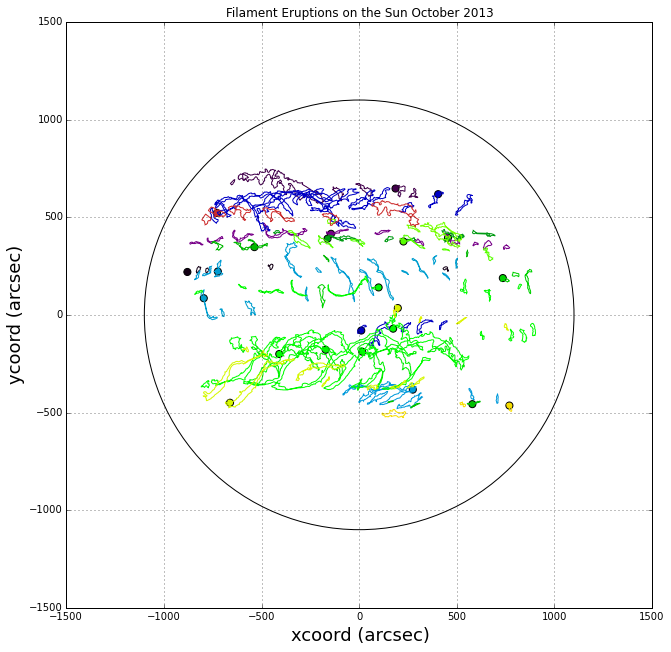

In [9]:
colorscale=[]
norm = mpl.colors.Normalize(vmin=0, vmax=3000)
cmap = plt.get_cmap('nipy_spectral')
m = cm.ScalarMappable(norm=norm, cmap=cmap)
for item in contained: #plotting those filaments that have eruptions contained within them
    scale1= m.to_rgba(item) 
    colorscale.append(scale1)

####plots eruptions/sun 
plt.grid(True)
plt.ylabel('ycoord (arcsec)',fontsize=18)
plt.xlabel('xcoord (arcsec)',fontsize=18)
plt.axis([-1500, 1500, -1500, 1500])
longitude = [elem["hpc_x"]for elem in filtered2]
latitude = [elem["hpc_y"] for elem in filtered2]
fig=plt.scatter(longitude,latitude,c= colorscale,s=50)
Sun=plt.Circle((0,0), radius=1100, color='black', fill=False)
plt.gcf().gca().add_artist(Sun)
plt.title('Filament Eruptions on the Sun October 2013')
fig1 = plt.gcf()
fig1.set_size_inches(10.5,10.5)
ax = fig1.add_subplot(111)
ax.set_aspect('equal') 

####plots filament tracks 
for poly in good_polygons: 
    scale=m.to_rgba(poly[0])
    plot_polygon=plt.Polygon(loads(poly[1]).exterior,color=scale,linewidth=1,fill=None)
    fig1.gca().add_artist(plot_polygon)
plt.show()

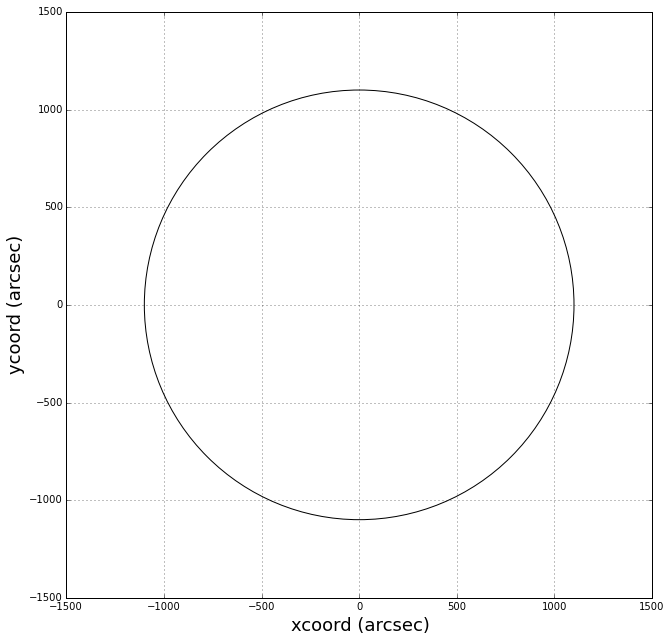

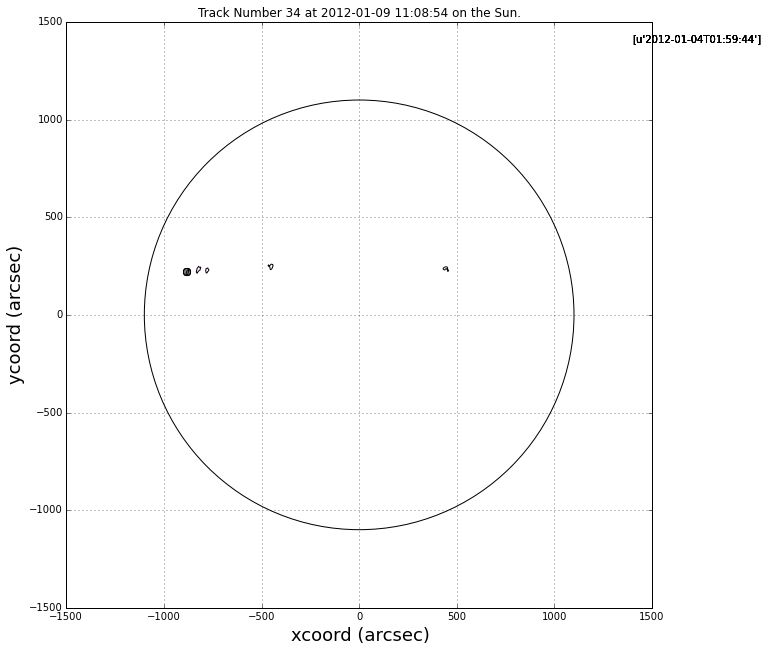

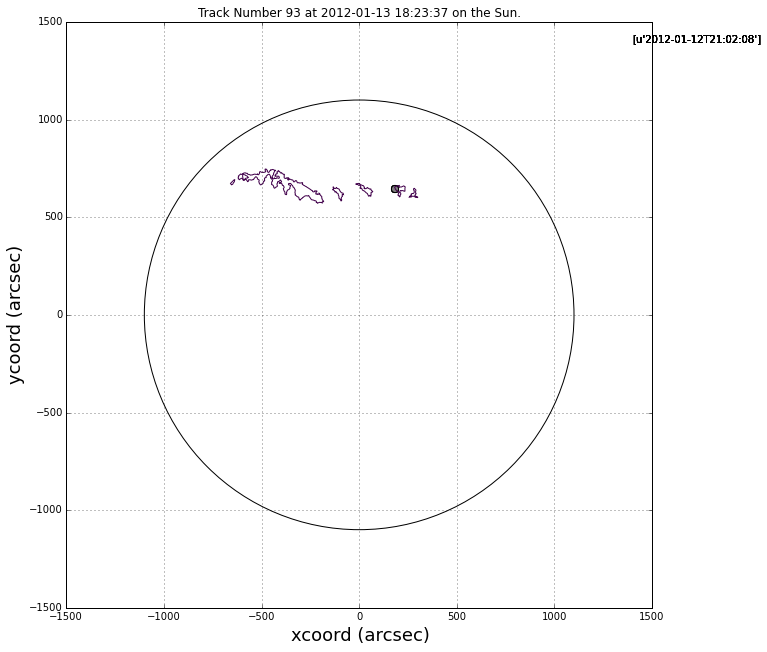

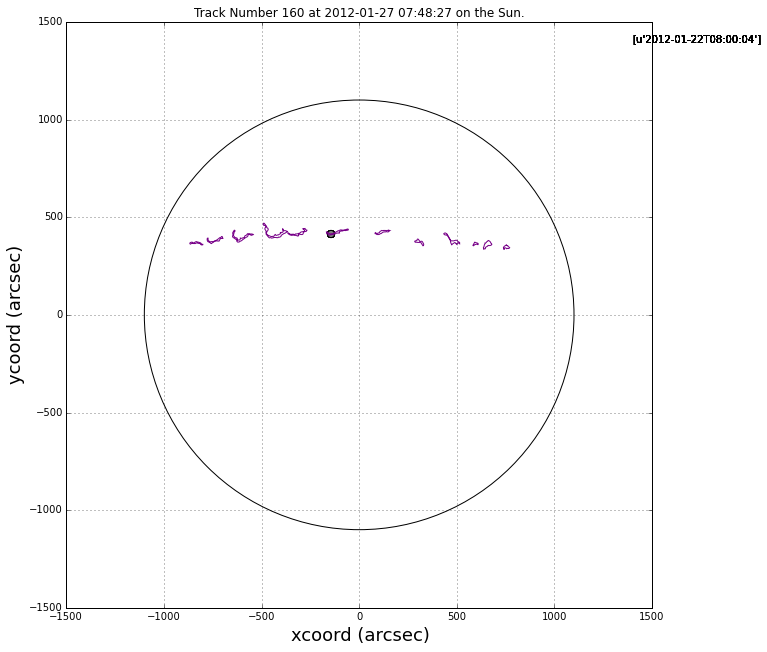

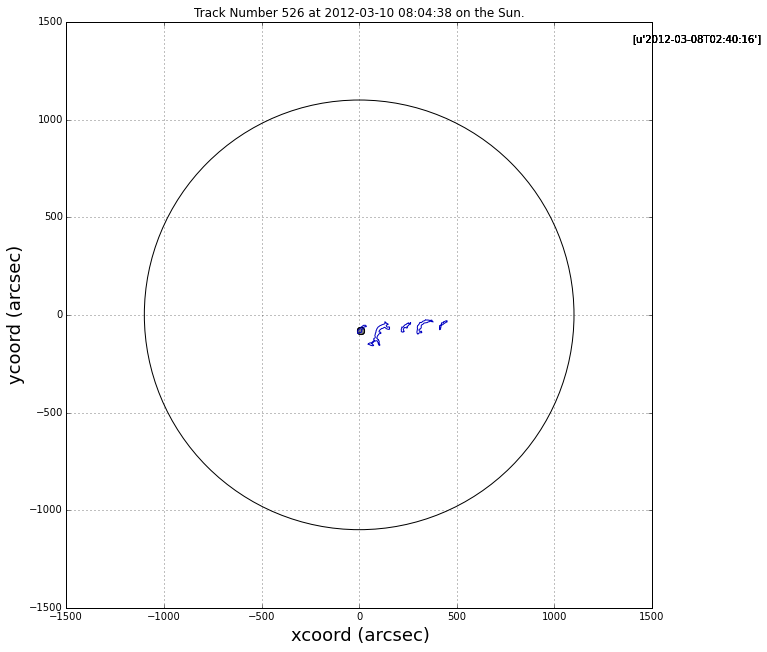

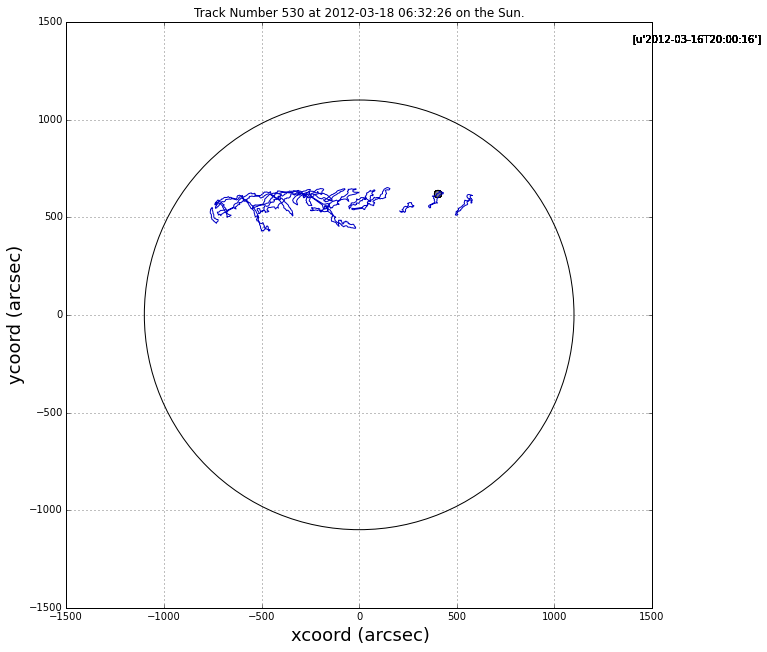

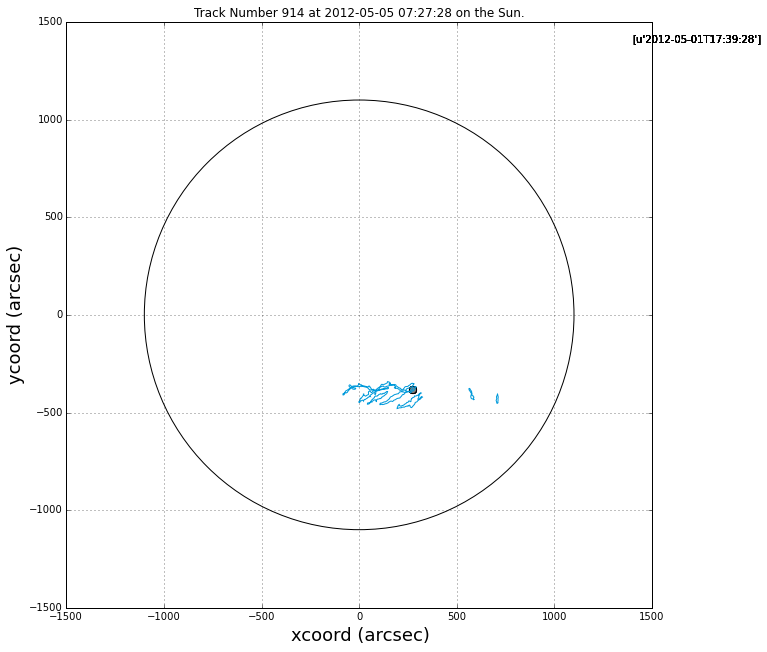

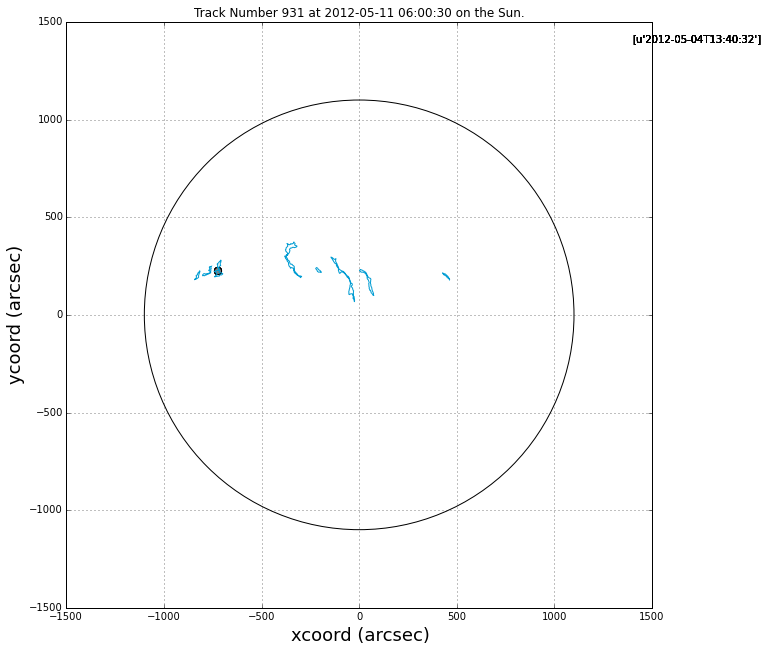

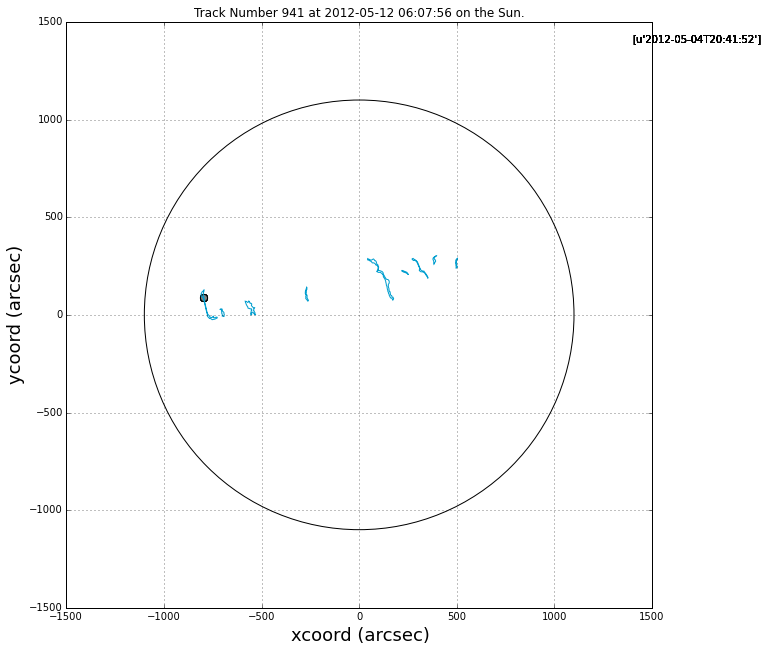

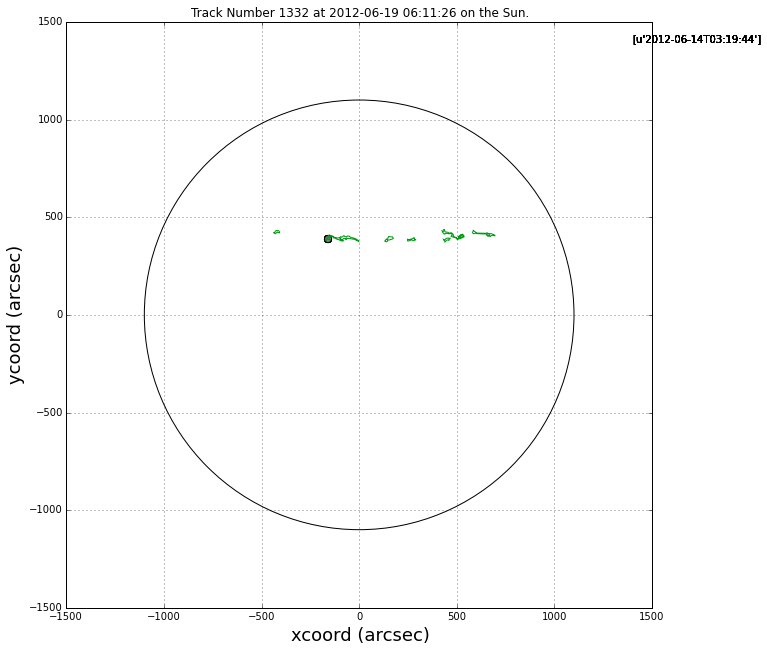

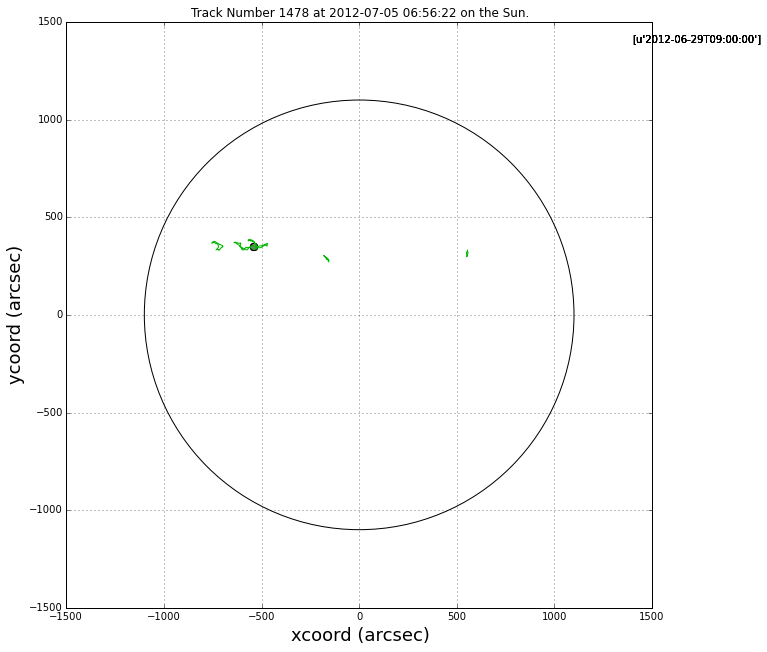

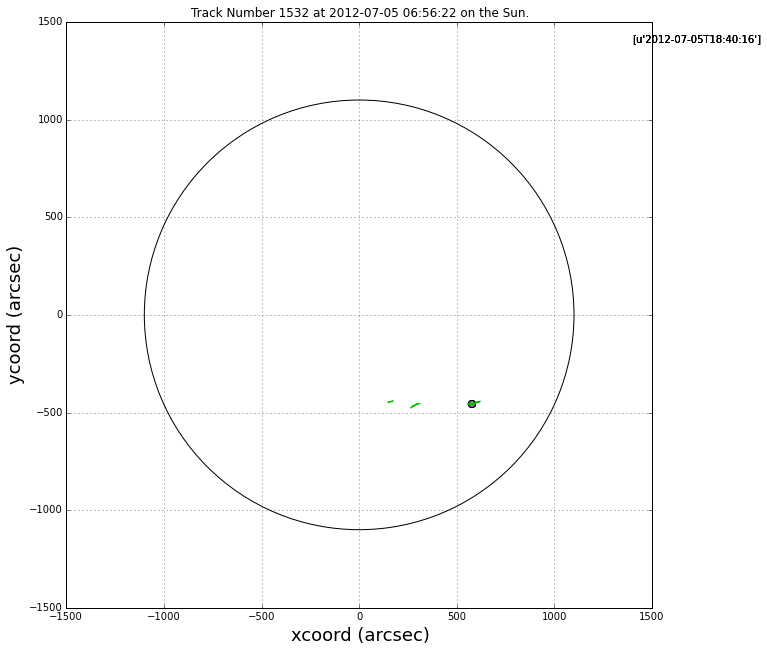

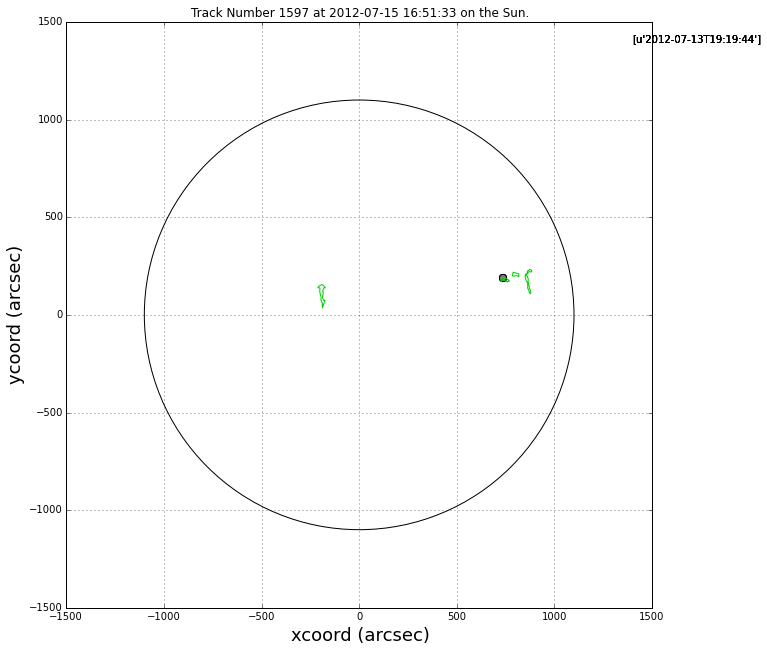

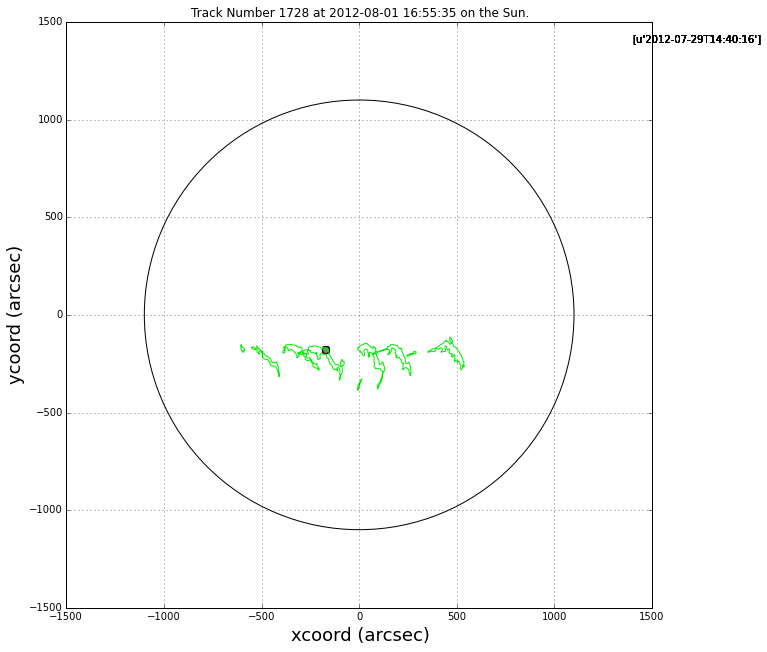

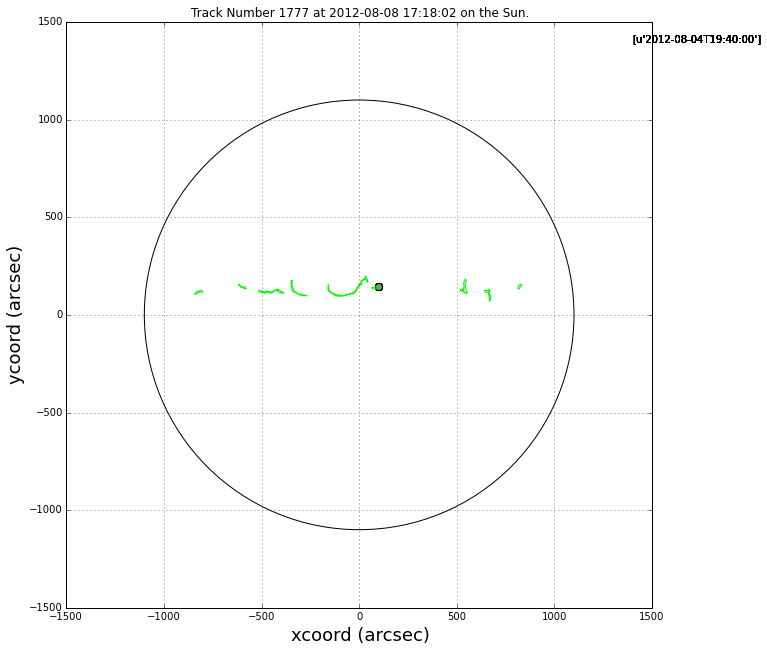

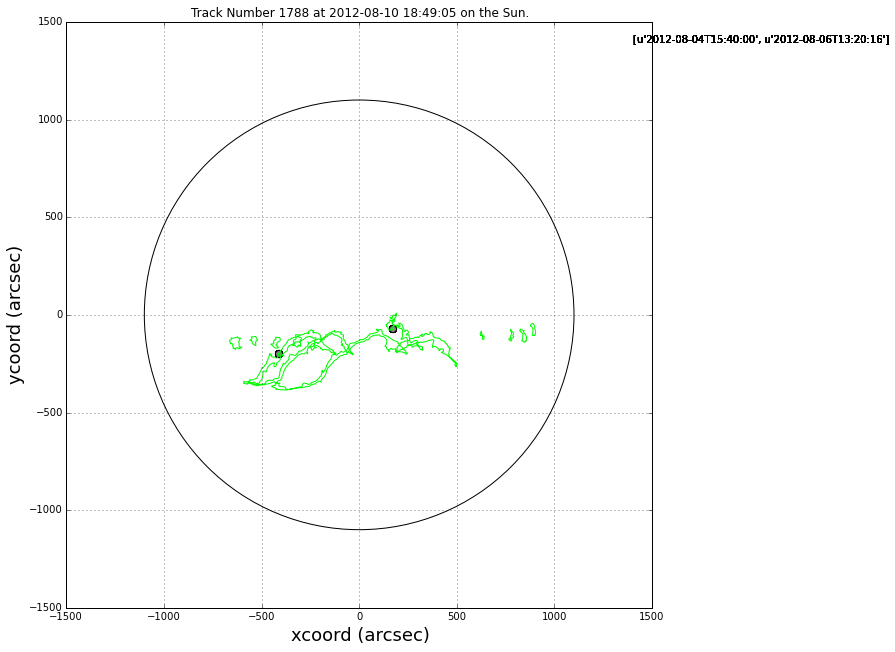

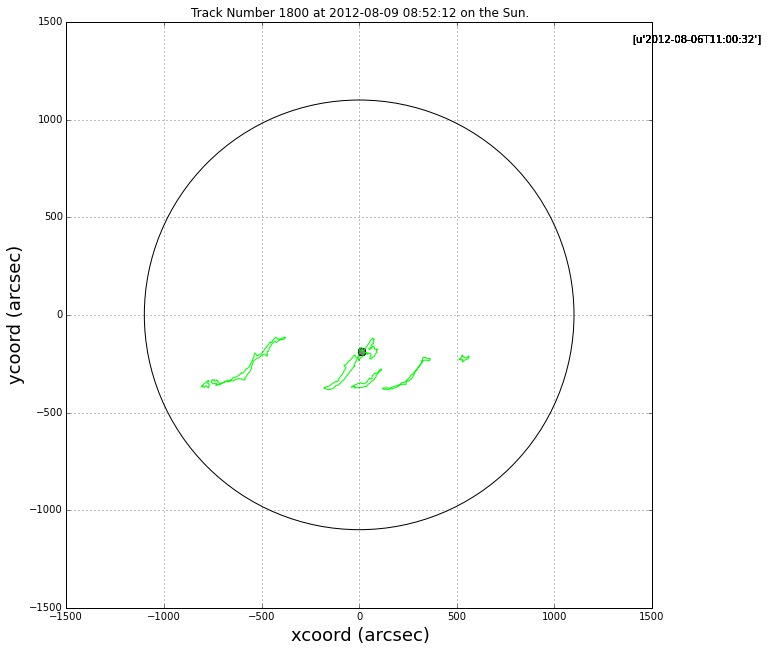

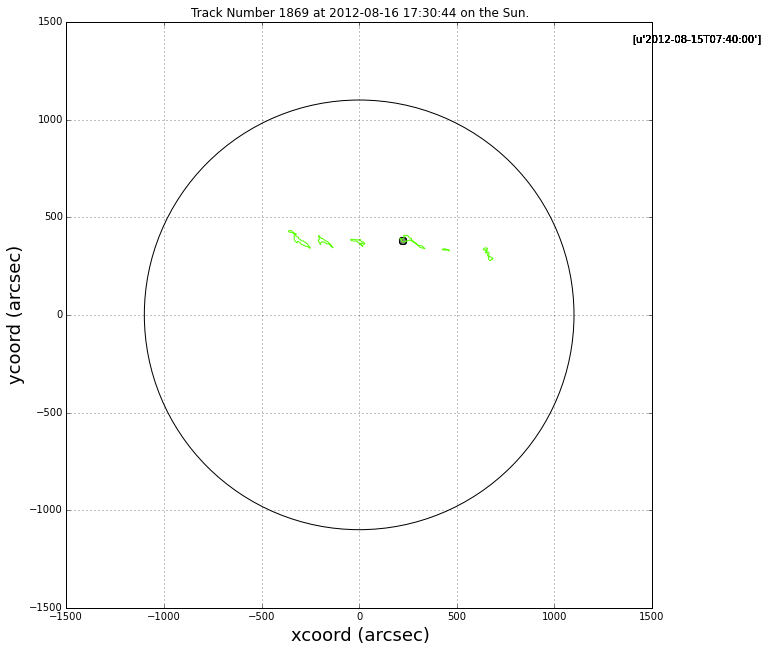

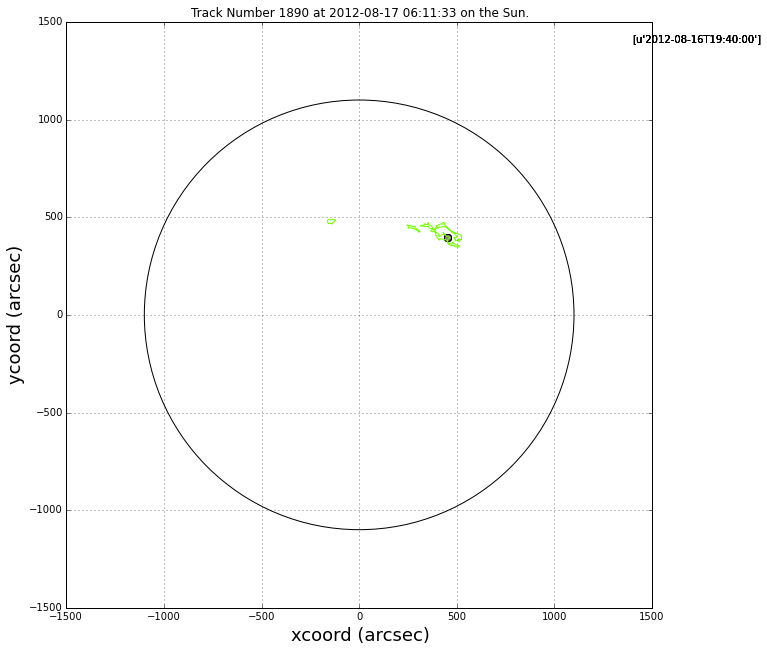

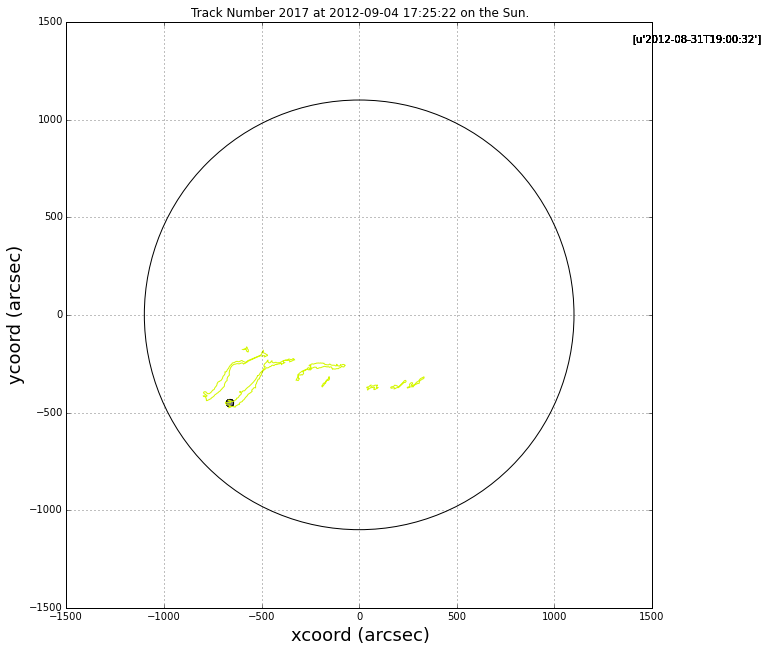

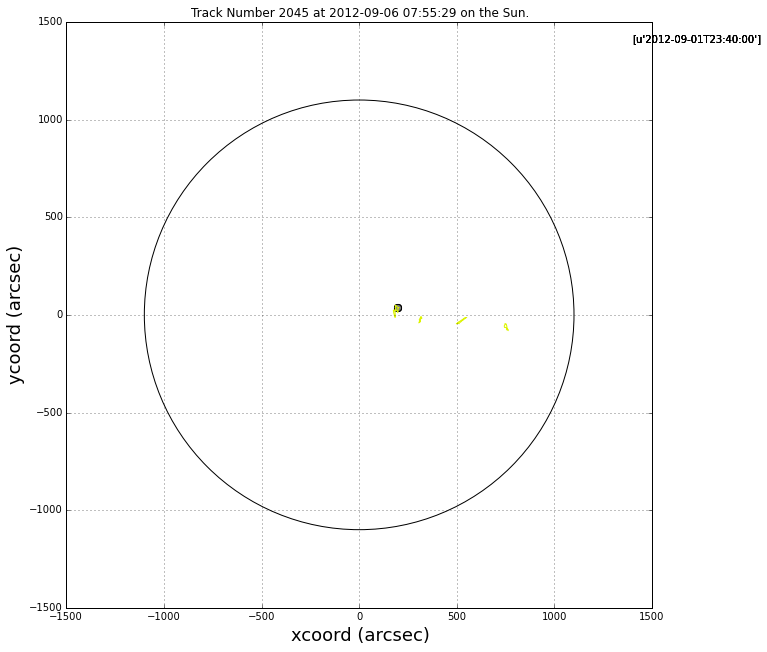

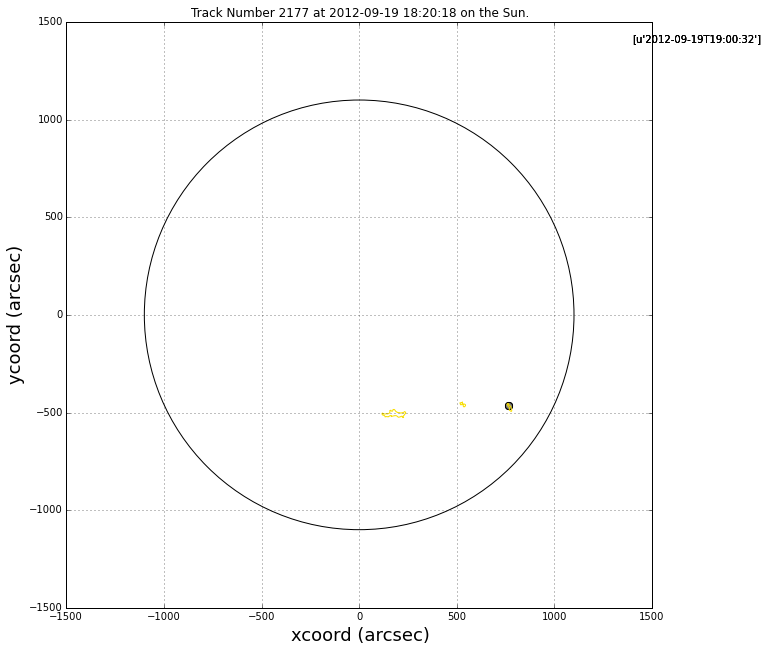

In [10]:
tot=[]
unique=[]
erupind=[]
contained_unique=np.unique(contained)
for tracks in contained_unique:
    tot.append(unique)
    unique=[]
    for i in range(0, len(good_tracks)):
        if tracks == good_tracks['Track No.'][i]:
            unique.append(i)
            
for item in tot:
    colorscale2=[]
    norm = mpl.colors.Normalize(vmin=0, vmax=3000)
    cmap = plt.get_cmap('nipy_spectral')
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    for thing1 in contained: #plotting those filaments that have eruptions contained within them
        scaleR= m.to_rgba(thing1) 
        colorscale2.append(scaleR)
####plots eruptions/sun
    plt.grid(True)
    plt.ylabel('ycoord (arcsec)',fontsize=18)
    plt.xlabel('xcoord (arcsec)',fontsize=18)
    plt.axis([-1500, 1500, -1500, 1500])
    #filtered4=[eruptions[i] for i in erupind]
    #longitude = [elem["hpc_x"]for elem in filtered3]
    #latitude = [elem["hpc_y"] for elem in filtered3]
    #fig=plt.scatter(longitude,latitude, c = colorscale2,s=50)
    fig1 = plt.gcf()
    Sun=plt.Circle((0,0), radius=1100, color='black', fill=False)
    plt.gcf().gca().add_artist(Sun)
    fig1.set_size_inches(10.5,10.5)
    ax = fig1.add_subplot(111)
    ax.set_aspect('equal')
        ##############################
    for i in range(0, len(item)):
        j=item[i]
        trnum=  good_tracks['Track No.'][j]
        stime=  good_tracks['HEK_time'][j]
        for thing1 in corresponding1:
            if thing1[0] == trnum:
                erupind.append(thing1[1])
        verup=[indices[i] for i in erupind]   #getting the eruption index from a list of possible indices
        erupind=[]
        filtered4=[eruptions[k] for k in verup]
        longitude = [elem["hpc_x"]for elem in filtered4]
        latitude = [elem["hpc_y"] for elem in filtered4]
        erup_t = [elem["event_starttime"] for elem in filtered4]
        plt.text(1400,1400,str(erup_t))
        #(interest[k][3], 28000000000,'Erup for Tr. %(Trackno)d' %{"Trackno": track},rotation=80)
        fig=plt.scatter(longitude,latitude, c = 'grey',s=50)
        scale2=m.to_rgba(good_tracks['Track No.'][j])
        plot_polygon=plt.Polygon(loads(good_tracks['HPC_BB_Poly'][j]).exterior,color=scale2,linewidth=1,fill=None)
        fig1.gca().add_artist(plot_polygon)
        plt.title('Track Number %(Trackno)d at %(starttime)s on the Sun.' % {"Trackno" : trnum, "starttime": stime})
    plt.show()

2177 2012-09-18 01:55:27
2177 2012-09-18 19:19:07
2177 2012-09-19 18:20:18


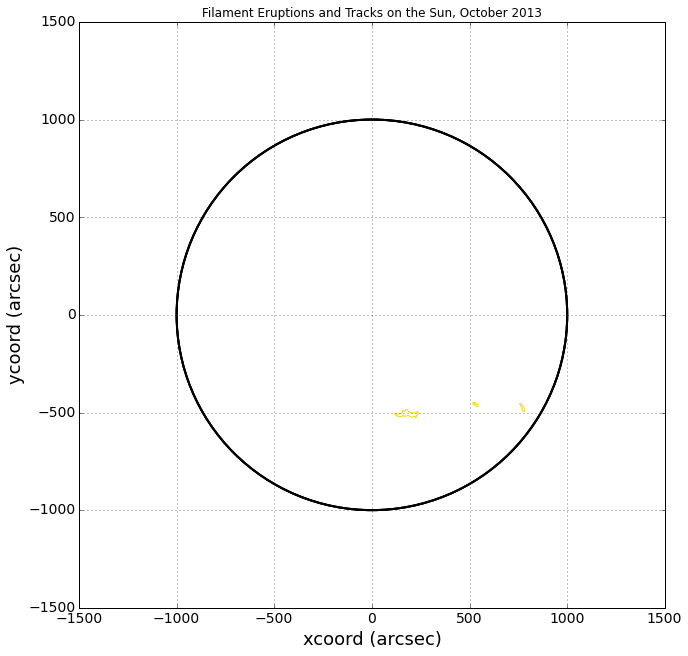

In [14]:
#### to check tracks that aren't "good" for some reason 
noerup=[]
check_track1=[2177]
check_poly1=[]
for i in range(len(good_tracks)): #iterating through the whole list of tracks 
    #if good_tracks['Track No.'][i] in intersected and good_tracks['Track No.'][i] in okay_filaments:   #if the track number is in the list created previously 
    if fi_tracked['Track No.'][i] in check_track1: 
            check_poly1.append((fi_tracked['Track No.'][i],fi_tracked['HPC_BB_Poly'][i])) #append the polygon data to good polygons
            print fi_tracked['Track No.'][i],fi_tracked['HEK_time'][i]
for poly in check_poly1: #plotting those filaments that have eruptions contained within them
    SetupSunPlotColor(noerup, poly[0], poly[1]) #filament eruption coordinates, track number, track polygon coordinates

